# Satellite Coastline Change Detection in the Three Bays Mangrove Forest, l'Estere, Haiti

In [94]:
import os
import gc
import json
import glob
import tarfile
import pyproj
import math
import itertools

import cv2 as cv
import numpy as np
import xarray as xr
import rasterio as rs
import rioxarray as rxr
import earthpy.plot as ep
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from natsort import natsorted
from datetime import datetime
from matplotlib import colors

## Data Acquisition

Getting and sorting .tar file paths from Bulk Download Landsat Ph.D Data directory

In [95]:
data_dir = 'F:/PhD Data/Landsat 2010-2022/*.tar'
tarpaths = []
# Suffixes and Prefixes to clean to easily sort by observation date 
sfs = ['_02_T1.tar','_02_T2.tar', '_02_T1_B1.TIF', '_02_T1_B2.TIF', '_02_T1_B3.TIF', '_02_T1_B4.TIF', '_02_T1_B5.TIF', '_02_T1_MTL.json',
        '_02_T2_B1.TIF', '_02_T2_B2.TIF', '_02_T2_B3.TIF', '_02_T2_B4.TIF', '_02_T2_B5.TIF', '_02_T2_MTL.json',
        '_02_T1_SR_B1.TIF', '_02_T1_SR_B2.TIF', '_02_T1_SR_B3.TIF', '_02_T1_SR_B4.TIF', '_02_T1_SR_B5.TIF', '_02_T1_ST_B6.TIF', '_02_T1_SR_B7.TIF', '_02_T1_MTL.json',
        '_02_T1_SR_B6.TIF', '_02_T2_SR_B6.TIF',
        '_02_T2_SR_B1.TIF', '_02_T2_SR_B2.TIF', '_02_T2_SR_B3.TIF', '_02_T2_SR_B4.TIF', '_02_T2_SR_B5.TIF', '_02_T2_ST_B6.TIF', '_02_T2_SR_B7.TIF', '_02_T2_MTL.json']
pfs = ['F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1GT_009047_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009047_', 
        'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LC08_L1TP_009046_', 'F:/PhD Data/Landsat 8 OLI_TIRS C2 L1\LO08_L1GT_009047_',
        'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009046_', 'F:/PhD Data/Landsat 2010-2022\LC08_L2SP_009047_',
        'F:/PhD Data/Landsat 2010-2022\LE07_L2SP_009047_',
        'extracted/2010/LC08_L1GT_009047_', 'extracted/2010/LC08_L1TP_009047_', 
        'extracted/2010/LC08_L1TP_009046_', 'extracted/2010/LC08_L1GT_009047_',
        'extracted/2010/LC08_L2SP_009046_', 'extracted/2010/LC08_L2SP_009047_',
        'extracted/2010/LE07_L2SP_009047_','extracted/2021/LC08_L1GT_009047_', 'extracted/2021/LC08_L1TP_009047_', 
        'extracted/2021/LC08_L1TP_009046_', 'extracted/2021/LC08_L1GT_009047_',
        'extracted/2021/LC08_L2SP_009046_', 'extracted/2021/LC08_L2SP_009047_',
        'extracted/2021/LE07_L2SP_009047_']
# Parse through .tar files in folder
for filepath in glob.iglob(data_dir):
    tarpaths.append(filepath)

# Returns observation date
def rm_prefsuf(x):
    for sf in sfs:
        x = x.removesuffix(sf)
    for pf in pfs:
        x = x.removeprefix(pf)
    return (x)[:-9]

# Sort list of paths by observation dates
tarpaths = natsorted(tarpaths, key=lambda x: datetime.strptime(rm_prefsuf(x), '%Y%m%d'))

Extent of mangrove forest for cropping

In [96]:
bay_p = 'shapefiles/mangrove_marsh_complex.shp'
bay_boundary = gpd.read_file(bay_p)

Retrieving .tar bands from all observations

In [163]:
rs.Env(VRT_SHARED_SOURCE = 0)

paths_first = []
paths_second = []
# Only grab bands 1 through 5
wanted = ['B1.TIF', 'B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF', 'B7.TIF', 'B8.TIF' 'MTL.json']
wanted_LS7 = ['B1.TIF', 'B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF', 'B6.TIF', 'B7.TIF', 'B8.TIF''MTL.json']

for tar in tarpaths:
    yr = (datetime.strptime(rm_prefsuf(tar), '%Y%m%d')).year
    if yr == 2013:
        paths_first.append(tar)
    if yr == 2021:
        paths_second.append(tar)

Extract band files for temporary use (only Bands 1 to 5) and calculate NDVI for observation day

In [164]:
band_paths = []
def extract_bands(path, year):
    current_date = datetime.strptime(rm_prefsuf(path), '%Y%m%d')
    archive1 = tarfile.open(path, 'r')
    archive1.getmembers()
    band_files = []
    for file in archive1.getmembers():
        #print(file.name + ': ' + str(file.name.endswith(tuple(wanted))))
        if file.name.endswith(tuple(wanted_LS7)):
            band_files.append(file)
            file.uname
    band_files = natsorted(band_files, key=lambda x: x.name)

    # Bands extraction
    for f in band_files:
        archive1.extract(f, path='extracted/' + str(year) + '/')
        # Stack bands in list and open metadata
    bands = []
    directory = 'extracted/' + str(year) + '/'
        # Looping over all GeoTIFF files
    i = 0
    for entry in os.scandir(directory):
        entry_date = datetime.strptime(rm_prefsuf(entry.path), '%Y%m%d')
        # Tries to open .TIF files of the current obs date, if that fails, know we reached the .json metadata file and get that instead
        if entry_date == current_date:
            try:
                fp = entry.path
                band_paths.append(fp)
                # Open and crop bands to mangrove extent
                bands.append(rxr.open_rasterio(fp).rio.clip(bay_boundary.geometry, from_disk=True).squeeze())
                bands[i]["Band"] = i+1
                i += 1
            except Exception as e:
                i = 0
                metadata = json.load(open(entry.path))
    return bands, current_date

Stack Observation values and take average for the year

In [218]:
bands10, date10 = extract_bands(paths_first[-1], 2021)
bands21, date21 = extract_bands(paths_second[-1], 2021)
ds10 = xr.concat(bands10, dim='Band')
ds21 = xr.concat(bands21, dim='Band')

### Visualization of Multispectral Cubes

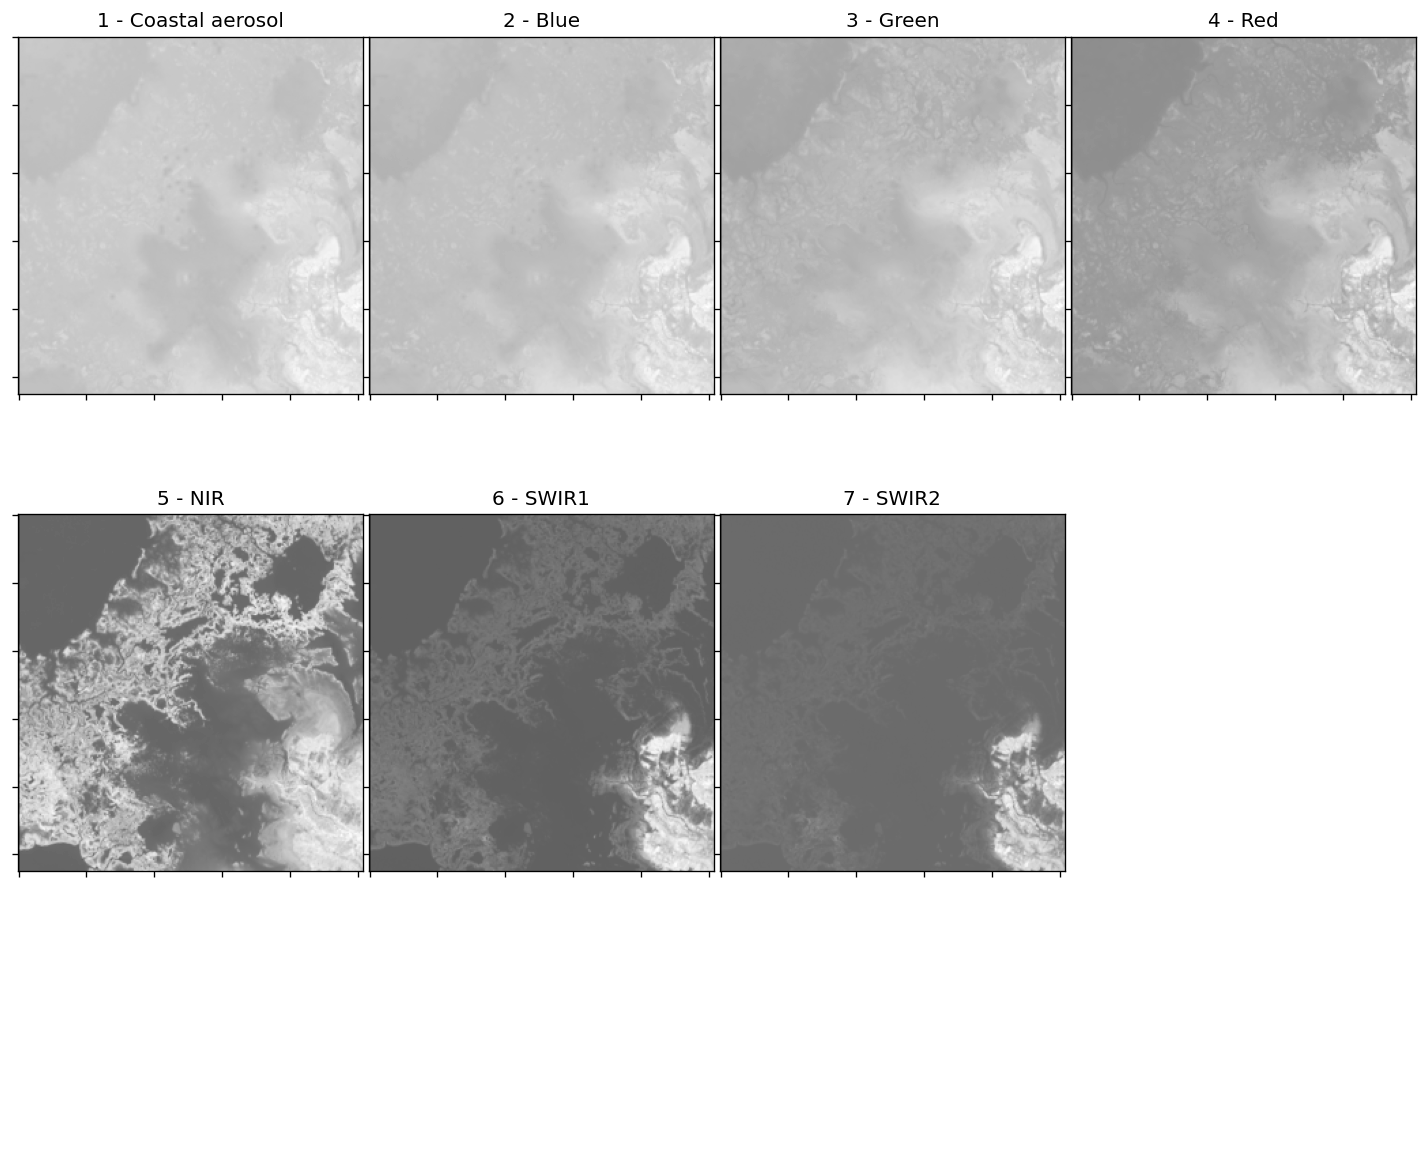

In [219]:
lan7bands = ['1 - Blue', '2 - Green', '3 - Red', '4 - NIR', '5 - SWIR1', '7 - SWIR2', '8 - Pan']
lan8bands = ['1 - Coastal aerosol', '2 - Blue', '3 - Green', '4 - Red', '5 - NIR', '6 - SWIR1', '7 - SWIR2']
fig, axs = plt.subplots(2,4, figsize=(12,12), dpi=120)
axs = list(itertools.chain.from_iterable(axs))

for i, band in enumerate(ds21.Band):
    axs[i].imshow(ds21[i], cmap='Greys_r')
    axs[i].set_title(lan8bands[i])
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    

plt.axis('off')
plt.tight_layout(w_pad=0, h_pad=-20)
plt.show()

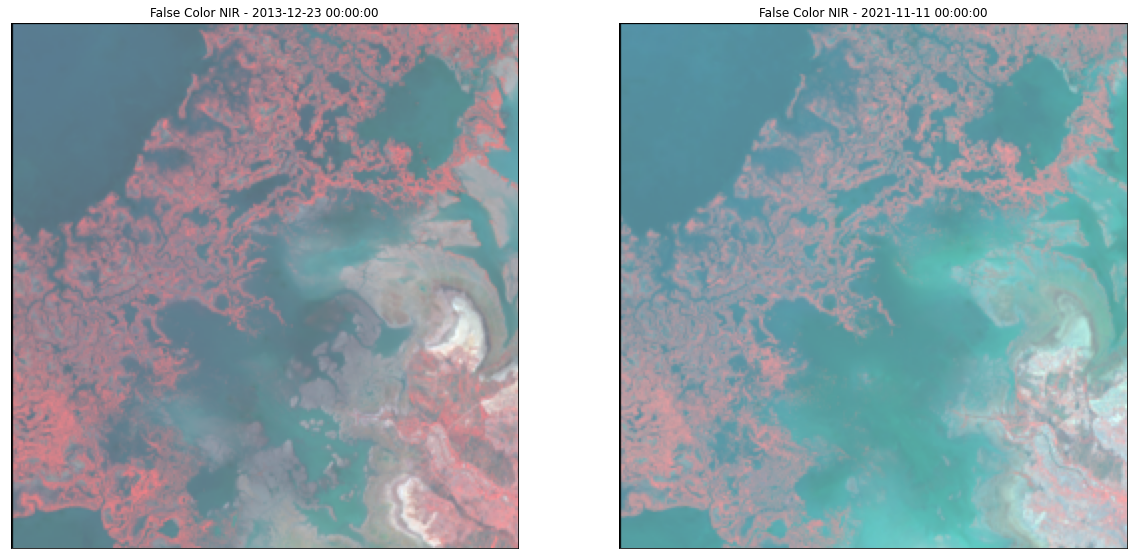

In [230]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,20))
ep.plot_rgb(ds10.values*1.5*2.3, rgb=[4,2,1], title="False Color NIR - " + str(date10), stretch=True,
            str_clip=0, ax=ax1)
ep.plot_rgb(ds21.values*1.5*2.3, rgb=[4,2,1], title="False Color NIR - " + str(date21), stretch=True,
            str_clip=0, ax=ax2)
plt.show()

## Automated Coastline Detection

### Segmentation

In [222]:
# Reshaping our multispectral cubes for clustering ops
W = (ds10[0].shape)[0]
H = (ds10[0].shape)[1]
acqVec1 = [band.values.reshape((W)*(H), 1) for band in ds10[2:5]]
acqVec2 = [band.values.reshape((W)*(H), 1) for band in ds21[4:7]]
acqVecs = [acqVec1, acqVec2]
reshapedDatasets = [np.array(acqVec).reshape(3, W*H).transpose() for acqVec in acqVecs]

reshapedDatasets[0].shape

(66802, 3)

In [223]:
# Segmenting through k-means
models = []

acquisitions = [ds10, ds21]
for resh in reshapedDatasets:
    print('Fitting model...')
    model = KMeans(2, max_iter=50, n_init=30, random_state=30)
    model.fit(resh)
    models.append(model)
    print('Done...')

Fitting model...
Done...
Fitting model...
Done...


Visualizing segmentation results

In [224]:
clusters = models[1].cluster_centers_
clusters

array([[ 8398.66841308,  7425.15829464,  7292.16822685],
       [14238.26559614, 10338.95469109,  8872.71020393]])

In [236]:
cluster1 = models[0].predict(reshapedDatasets[0])
cluster2 = models[1].predict(reshapedDatasets[1])
clusters = [cluster1, cluster2]

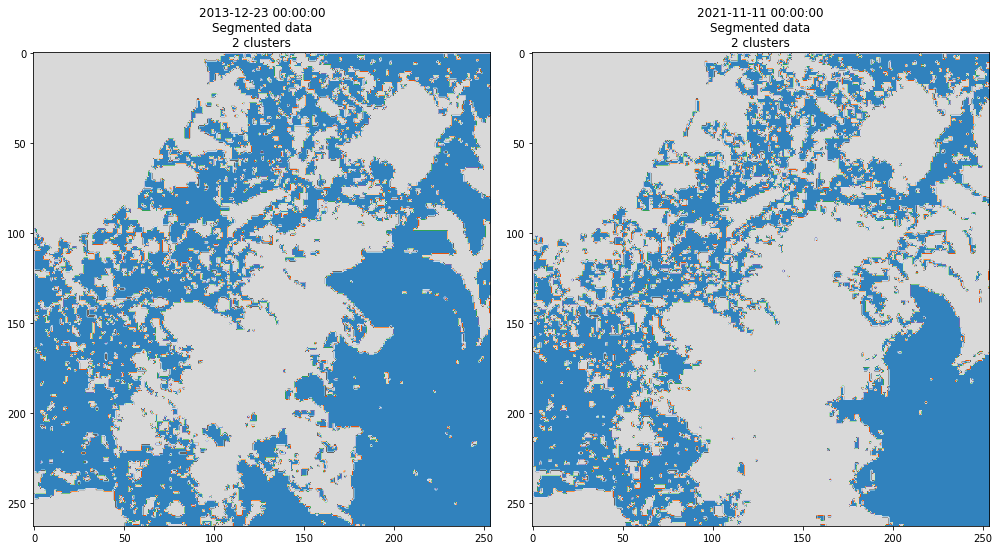

In [237]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,10))

ax1.imshow(cluster1.reshape(ds10[0].shape), cmap='tab20c_r')
ax1.set_title(str(date10)+'\nSegmented data\n2 clusters')
ax2.imshow(cluster2.reshape(ds21[0].shape), cmap='tab20c_r')
ax2.set_title(str(date21)+'\nSegmented data\n2 clusters')

plt.tight_layout()
plt.show()

### Canny Edge Implementation

Noise Reduction with Gaussian Filtering

Text(0.5, 1.0, '2021-11-11 00:00:00\nGaussian Blurred Image')

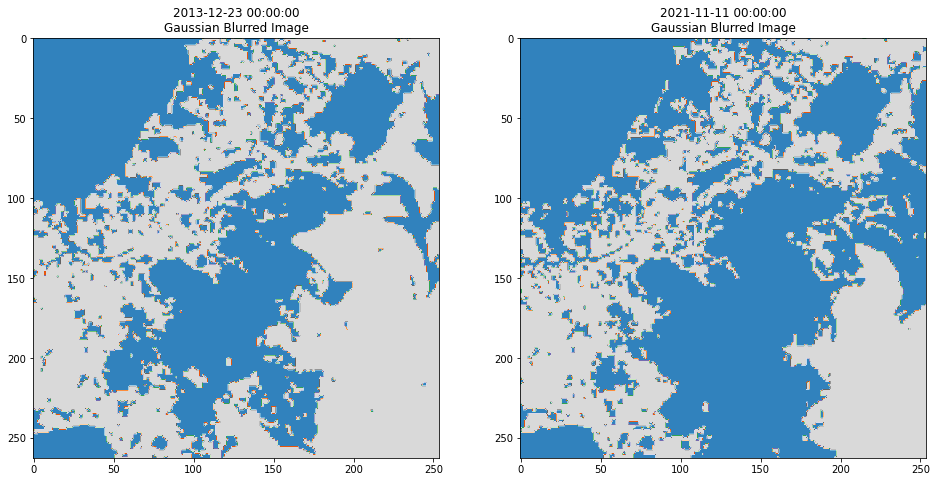

In [238]:
clusteredImages = [clusterLabels.reshape(ds10[0].shape).astype("uint8") for clusterLabels in clusters]
blurredImages = [cv.GaussianBlur(clusteredImage, (3,3), 0) for clusteredImage in clusteredImages]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,30))
ax1.imshow(blurredImages[0], cmap='tab20c')
ax1.set_title(str(date10)+'\nGaussian Blurred Image')
ax2.imshow(blurredImages[1], cmap='tab20c')
ax2.set_title(str(date21)+'\nGaussian Blurred Image')

### Coastline Detection

Canny Detector

In [239]:
rawEdges = [cv.Canny(blurredImage, 2,5).astype('float').reshape(clusteredImages[0].shape) for blurredImage in blurredImages]
edges = []
for edge in rawEdges:
    edge[edge==0] = np.nan
    edges.append(edge)

### Coastline Change

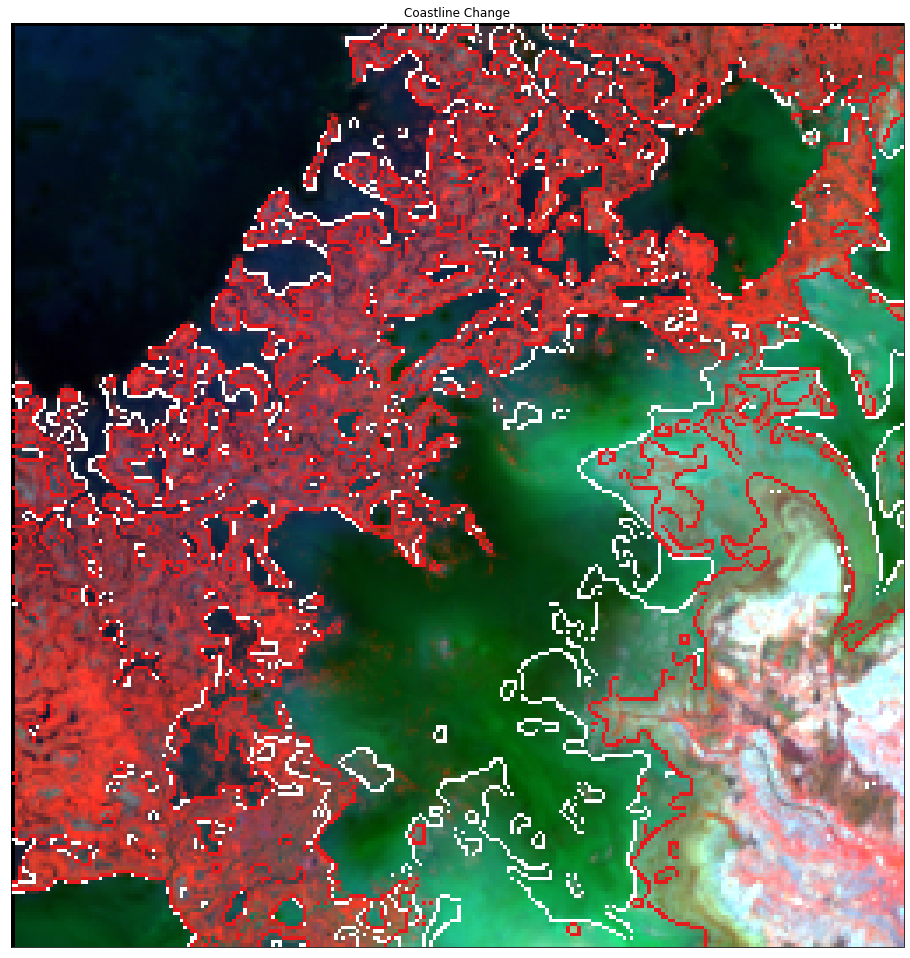

In [265]:
fig, ax = plt.subplots(figsize=(16,30))
ep.plot_rgb(ds21.values*1.5*2.3, rgb=[4,2,0], stretch=True,
            str_clip=.85, ax=ax)
ax.imshow(edges[0], cmap='Greys')
ax.imshow(edges[1], cmap='Set1')
plt.title('Coastline Change')
plt.show()